In [2]:
# load required R packages
# 载入需要的R包
library(tidyverse)
library(DESeq2)
library(BioSeqUtils)
library(caret)
library(randomForest)
library(ROCR) 
library(pROC)
library(ggplot2)
library(PRROC)
library(tidymodels)
library(Seurat)
library(patchwork)
library(ggsci)
library(kmer)
library(readxl)
library(Biostrings)
library(ape)
library(pheatmap)
library(ggplotify)
library(GenomicFeatures)
library(parallel)
library(venn)
library(universalmotif)
library(data.table)
library(clusterProfiler)

In [3]:
#setting working directory
# 设置工作路径
setwd("D:\\project\\白骨壤Cd")

In [4]:
theme_cleveland <- function (rotate = TRUE) 
{
    if (rotate) {
        theme(panel.grid.major.x = element_blank(), panel.grid.minor.x = element_blank(), 
            panel.grid.major.y = element_line(colour = "grey70", 
                linetype = "dashed"))
    }
}

In [5]:
# custom function for differentially expressed genes analysis using DESeq2 R package
# 构建函数，使用DESeq2进行差异表达分析
DEG <- function(count,sampleNames,comparison,rep=3){
    data <- count[,sampleNames]
    countData <- as.matrix(data)
    condition <- c(rep("control",rep),rep("treatment",rep))
    database <- data.frame(name=sampleNames, condition=condition)
    database$condition <- factor(database$condition)
    rownames(database) <- sampleNames
    dds <- DESeqDataSetFromMatrix(countData, colData=database, design= ~ condition)
    dds <- dds[ rowSums(counts(dds)) > 10, ]
    dds <- DESeq(dds)
    res <- results(dds,contrast=c("condition", "treatment", "control"))
    res <- res %>%
        as.data.frame() %>%
        mutate(comparison=comparison,gene=rownames(res))
    return(res)
}

In [6]:
# custom function for reading gene expression in raw counts format
# 读取基因表达数据(格式raw counts)
read_count <- function(path="03_raw_counts/",file="Avicennia_marina.counts"){
    Count <- read.table(paste0(path,file),head=T,check.names = F,row.names=1)
    Count <- Count %>%
        dplyr::select(-c(Chr,Start,End,Strand,Length))
    if(file %in% c('Athaliana.counts','Ntab.counts','HvulgareMorex.counts')){
        Cols <- lapply(colnames(Count),function(x){
            unlist(str_split(x,'[/.]'))[2]
        })        
    }else{
        Cols <- lapply(colnames(Count),function(x){
            unlist(str_split(x,'[-.]'))[3]
        }) 
    }
    colnames(Count) <- unlist(Cols)
    return(Count)
}

In [7]:
load("Cis/Am_DEG.RData")
load("Cis/At_DEG.RData")
load("Cis/HvulgareMorex_DEG.RData")
load("Cis/Ntab_DEG.RData")

In [8]:
DEGs <- rbind(Am_DEG,At_DEG,HvulgareMorex_DEG,Ntab_DEG)

In [9]:
fdr <- 0.05
log2FC <- 1
DEGs$group <- case_when(
        DEGs$log2FoldChange > log2FC & DEGs$padj < fdr ~ "Up",
        DEGs$log2FoldChange < -log2FC & DEGs$padj < fdr ~ "Down",
        TRUE ~ 'None'
)

In [10]:
DEGs$group[abs(DEGs$log2FoldChange)<0.5] <- "NRG"

In [11]:
table(DEGs$group)


 Down  None   NRG    Up 
 5378 26008 67750  6467 

In [12]:
table(DEGs[,c('group','Organism')])

      Organism
group  Arabidopsis thaliana Avicennia marina Hvulgare Morex Nicotiana tabacum
  Down                  330             1530           2327              1191
  None                 3358             6176           7526              8948
  NRG                 16174            16931           9905             24740
  Up                    491              890           2028              3058

In [ ]:
#save(DEGs,file="Cis/fourSpecies_DEG.RData")

In [13]:
load("Cis/fourSpecies_DEG.RData")

In [15]:
roclist <- NULL
IMP <- NULL
AUC <- c()
for(org in c("Avicennia marina","Arabidopsis thaliana","Hvulgare Morex","Nicotiana tabacum")){
    f <- paste0("Cis/",org,"_motif_model.Rdata")
    print(f)
    load(f)
    imp <- rf$importance %>%
            as.data.frame() 
    imp <- imp %>%
        mutate(motif=rownames(imp)) %>%
        arrange(desc(MeanDecreaseAccuracy)) %>%
        mutate(Organism=org) %>%
        mutate(importance=(MeanDecreaseAccuracy-min(MeanDecreaseAccuracy))/(max(MeanDecreaseAccuracy)-min(MeanDecreaseAccuracy))) %>%
        head(10)
    IMP <- rbind(IMP,imp)
    rf_pred <- predict(rf,test,type="prob")
    predob <- prediction(rf_pred[,2], test$class)
    perf <- performance(predob, 'tpr','fpr')
    perf.auc<- performance(predob, measure = 'auc', x.measure = 'cutoff')
    Auc <- paste0("AUC-ROC: ",sprintf("%.3f",unlist(perf.auc@y.values)))
    print(Auc)
    AUC <- c(AUC,Auc)
    re <- data.frame(x = attributes(perf)$x.values[[1]],
                     y = attributes(perf)$y.values[[1]],
                     Organism=org)
    roclist <- rbind(roclist,re)
}

[1] "Cis/Avicennia marina_motif_model.Rdata"
[1] "AUC-ROC: 0.971"
[1] "Cis/Arabidopsis thaliana_motif_model.Rdata"
[1] "AUC-ROC: 0.996"
[1] "Cis/Hvulgare Morex_motif_model.Rdata"
[1] "AUC-ROC: 0.871"
[1] "Cis/Nicotiana tabacum_motif_model.Rdata"
[1] "AUC-ROC: 0.963"


In [16]:
labels <- data.frame(Organism=c('Avicennia marina','Arabidopsis thaliana','Hvulgare Morex','Nicotiana tabacum'),
                      label = AUC)

# Figure 5A

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


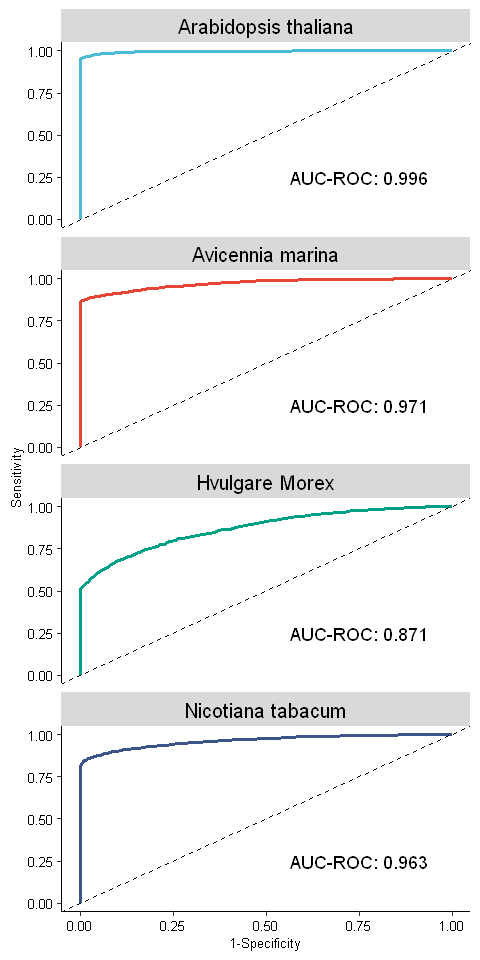

In [17]:
options(repr.plot.width=4, repr.plot.height=8)
Figure5A <- roclist %>%
  ggplot()+
  geom_line(aes(x,y,color=Organism),size = 1) + 
  xlab("1-Specificity") +
  ylab("Sensitivity") +
  facet_wrap(~Organism,ncol=1)+
  theme(axis.text=element_text(size=8,color='black'),
        axis.title=element_text(size=8),
        axis.text.x = element_text(angle=0),
        panel.background = element_blank(),
        legend.position='none',strip.text.x = element_text(size = 12, colour = "black"),
        #strip.background = element_rect(color="white",fill='white'),
        axis.line = element_line(colour = "black",size = 0.5))+
  geom_text(x = 0.75, y = 0.25, aes(label = label), data = labels)+
  geom_abline(intercept = 0, slope = 1,linetype='dashed')+
scale_color_manual(values = c('#4dbbd5','#e64635','#00a087','#3c5488'))
Figure5A

# Figure 5B

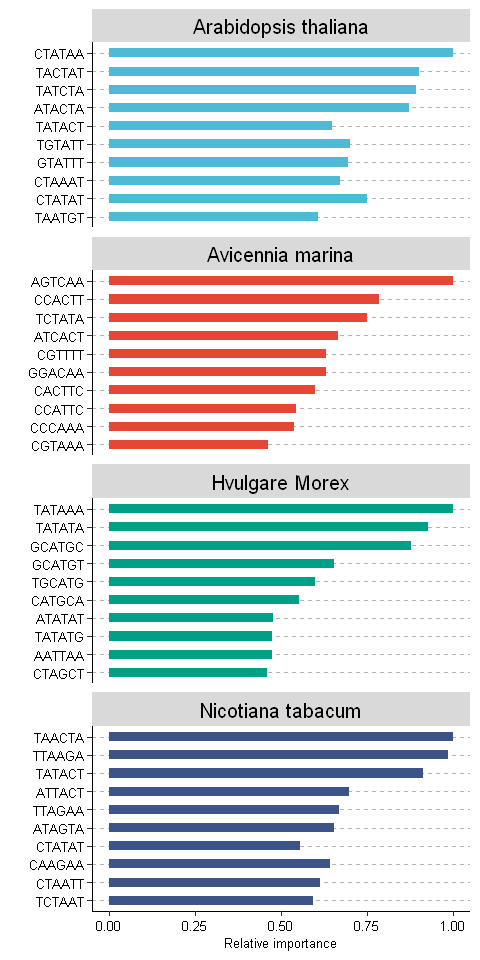

In [19]:
options(repr.plot.width=4, repr.plot.height=8)
Figure5B <- IMP %>%
    ggplot(aes(reorder(motif,importance),importance,fill=Organism))+
        geom_bar(stat='identity',width=0.5)+
    facet_wrap(~Organism,scale='free_y',ncol=1)+
    theme_cleveland()+
        theme(axis.text=element_text(size=8,color='black'),
              axis.title=element_text(size=8),
               axis.text.x = element_text(angle=0),
              panel.background = element_blank(),
              legend.position='none',strip.text = element_text(size = 12, colour = "black"),
              #strip.background = element_rect(color="white",fill='white'),
             axis.line = element_line(colour = "black",size = 0.5))+
ylab('Relative importance')+xlab('')+
coord_flip()+
scale_fill_manual(values = c('#4dbbd5','#e64635','#00a087','#3c5488'))
Figure5B